**Initialization**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [7]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading Libraries and Dependencies**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [27]:
#@ IMPORTING MODULES: UNCOMMENT BELOW:
# !pip install transformers[sentencepiece]
# !pip install datasets
import torch
import torch.nn.functional as F
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer
import pandas as pd
from datasets import list_datasets
from datasets import load_dataset
import matplotlib.pyplot as plt

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

**The Dataset**

In [9]:
#@ INITIALIZING THE DATASET:
all_datasets = list_datasets()                                  # Initializing datasets. 
print(f"There are {len(all_datasets)} available datasets.")     # Initializing number of datasets.
print(f"The first 10 datasets are: {all_datasets[:10]}")        # Inspecting datasets. 

There are 4207 available datasets.
The first 10 datasets are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [10]:
#@ LOADING THE DATASET:
emotions = load_dataset("emotion")              # Loading emotion dataset.
emotions                                        # Inspecting dataset.

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [11]:
#@ INSPECTING DATASET:
train_ds = emotions["train"]                    # Initializing training dataset.
print(train_ds)                                 # Inspecting training dataset.
print(len(train_ds))                            # Inspecting length.
print(train_ds[0])                              # Inspecting a dataset.
print(train_ds.column_names)                    # Inspecting keys of dataset.

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
16000
{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']


In [12]:
#@ INSPECTING THE DATASET:
print(train_ds.features)                       # Inspecting data types.
print(train_ds[:5])                            # Inspecting dataset.
print(train_ds["text"][:5])                    # Inspecting text column. 

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


**Datasets to DataFrames**

In [13]:
#@ INITIALIZING PANDAS DATAFRAME:
emotions.set_format(type="pandas")             # Changing data format. 
df = emotions["train"][:]                      # Initializing dataframe.
df.head()                                      # Inspecting dataframe.

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [14]:
#@ INITIALIZING LABEL NAME:
def label_int2str(row):                                         # Defining function. 
    return emotions["train"].features["label"].int2str(row)     # Converting integers into string.
df["label_name"] = df["label"].apply(label_int2str)             # Updating dataframe.
df.head()                                                       # Inspecting dataframe.

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


**Looking Class Distributions**

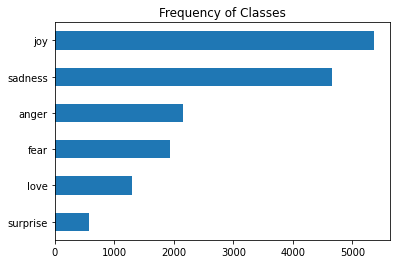

In [15]:
#@ INSPECTING CLASS DISTRIBUTIONS:
df["label_name"].value_counts(ascending=True).plot.barh()       # Creating a bar graph. 
plt.title("Frequency of Classes")                               # Initializing title.
plt.show()

**Note:**
- We can see that the dataset is heavily imbalanced: the joy and sadness classes appear frequently, whereas love and surprise are rare. Ways to deal with imbalanced data:
    - Randomly oversample the minority class.
    - Randomly undersample the majority class. 
    - Gather more labeled data from the underrepresented classes. 

**Tweets Length**

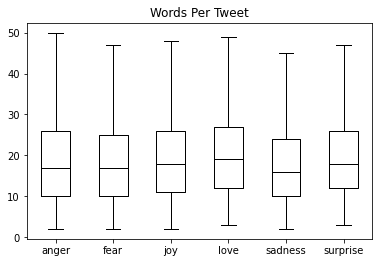

In [16]:
#@ INSPECTING TWEETS LENGTH:
df["Words Per Tweet"] = df["text"].str.split().apply(len)       # Inspecting input sequence length.
df.boxplot("Words Per Tweet", by="label_name", grid=False,
           showfliers=False, color="black")                     # Creating a box plot.
plt.suptitle("")
plt.xlabel("")
plt.show()

In [17]:
#@ RESETING DATA FORMAT:
emotions.reset_format()

**Text to Tokens**
- **Tokenization** is the step of breaking down a string into the atomic units used in the model. **Numericalization** is the process of converting tokens into integer. 

**Character Tokenization**

In [18]:
#@ IMPLEMENTATION OF CHARACTER TOKENIZATION: 
text = "Tokenization is the step of breaking down."         # Initializing text example. 
tokenized_text = list(text)                                 # Character tokenization. 
print(tokenized_text)                                       # Inspection.

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'a', 't', 'i', 'o', 'n', ' ', 'i', 's', ' ', 't', 'h', 'e', ' ', 's', 't', 'e', 'p', ' ', 'o', 'f', ' ', 'b', 'r', 'e', 'a', 'k', 'i', 'n', 'g', ' ', 'd', 'o', 'w', 'n', '.']


In [19]:
#@ INITIALIZING NUMERICALIZATION:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}     # Initializing numericalization.
print(token2idx)                                                                # Inspection.

{' ': 0, '.': 1, 'T': 2, 'a': 3, 'b': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'p': 14, 'r': 15, 's': 16, 't': 17, 'w': 18, 'z': 19}


In [20]:
#@ INITIALIZING NUMERICALIZATION:
input_ids = [token2idx[token] for token in tokenized_text]                      # Numericalization.
print(input_ids)                                                                # Inspection.

[2, 13, 11, 6, 12, 10, 19, 3, 17, 10, 13, 12, 0, 10, 16, 0, 17, 9, 6, 0, 16, 17, 6, 14, 0, 13, 7, 0, 4, 15, 6, 3, 11, 10, 12, 8, 0, 5, 13, 18, 12, 1]


In [21]:
#@ INITIALIZING ONE HOT ENCODING:
categorical_df = pd.DataFrame({"Name": ["Bumblebee", "Optimus Prime", "Megatron"], 
                               "Label ID": [0, 1, 2]})                              # Example dataframe.
pd.get_dummies(categorical_df["Name"])                                              # One-hot encoding.

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [22]:
#@ ONE HOT ENCODING WITH PYTORCH:
input_ids = torch.tensor(input_ids)                                     # Converting into tensors.
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))    # One-hot encoding.
one_hot_encodings.shape                                                 # Inspecting shape.

torch.Size([42, 20])

In [23]:
#@ INSPECTING CHARACTER LEVEL TOKENIZATION:
print(f"Token: {tokenized_text[0]}")                                    # Inspection.
print(f"Tensor index: {input_ids[0]}")                                  # Inspection.
print(f"One-hot: {one_hot_encodings[0]}")                               # Inspection.

Token: T
Tensor index: 2
One-hot: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


**Word Tokenization**

In [24]:
#@ INITIALIZING WORD TOKENIZATION:
tokenized_text = text.split()                               # Initializing word tokens.
print(tokenized_text)                                       # Inspecting tokens.

['Tokenization', 'is', 'the', 'step', 'of', 'breaking', 'down.']


**Subword Tokenization**
- Subword tokenization combines the best aspects of character and word tokenization. It splits rare words into smaller units to allow the model to deal with complex words and misspellings and it keeps frequent words as unique entities so that the length of inputs are kept to a manageable size. 

In [29]:
#@ INITIALIZING SUBWORD TOKENIZATION:
model_ckpt = "distilbert-base-uncased"                                      # Initializing model checkpoint.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)                       # Initializing pretrained tokenizer. 
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)      # Initializing pretrained tokenizer. 

**DistilBERT**
- The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient.